In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/braincancerclassifiaction-initial-training'):
    
    print(os.path.join(dirname))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/braincancerclassifiaction-initial-training
/kaggle/input/braincancerclassifiaction-initial-training/BCCv4
/kaggle/input/braincancerclassifiaction-initial-training/BCCv4/variables
/kaggle/input/braincancerclassifiaction-initial-training/__results___files


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
batch_size = 32
img_height = 224
img_width = 224

import os
train_dir = ""
for dirname, _, filenames in os.walk('/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/train'):
    print(os.path.join(dirname))
    train_dir = os.path.join(dirname)
    break
print(train_dir)

val_dir = ""
for dirname, _, filenames in os.walk('/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/val'):
    print(os.path.join(dirname))
    val_dir = os.path.join(dirname)
    break
print(val_dir)

/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/train
/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/train
/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/val
/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images/val


In [4]:
import pathlib
train_dir = pathlib.Path(train_dir)
images = list(train_dir.glob('*/*.jpg'))
train_image_count = len(images)
print("Train Images - ", train_image_count)

val_dir = pathlib.Path(val_dir)
images = list(val_dir.glob('*/*.jpg'))
val_image_count = len(images)
print("Validation Images - ", val_image_count)

Train Images -  9804
Validation Images -  2452


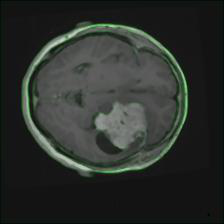

In [5]:
#1 - Meningioma , 2 - Glioma, 3 - Pitutary
Meningioma = list(train_dir.glob('1/*'))
PIL.Image.open(str(Meningioma[0]))

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode= 'categorical', 
  crop_to_aspect_ratio=True )

Found 9804 files belonging to 3 classes.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode= 'categorical',
  crop_to_aspect_ratio= True )

Found 2452 files belonging to 3 classes.


In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 62
Number of test batches: 15


In [9]:
class_names = train_ds.class_names
classes = ["Meningioma","Glioma" ,"Pitutary"]
class_names

['1', '2', '3']

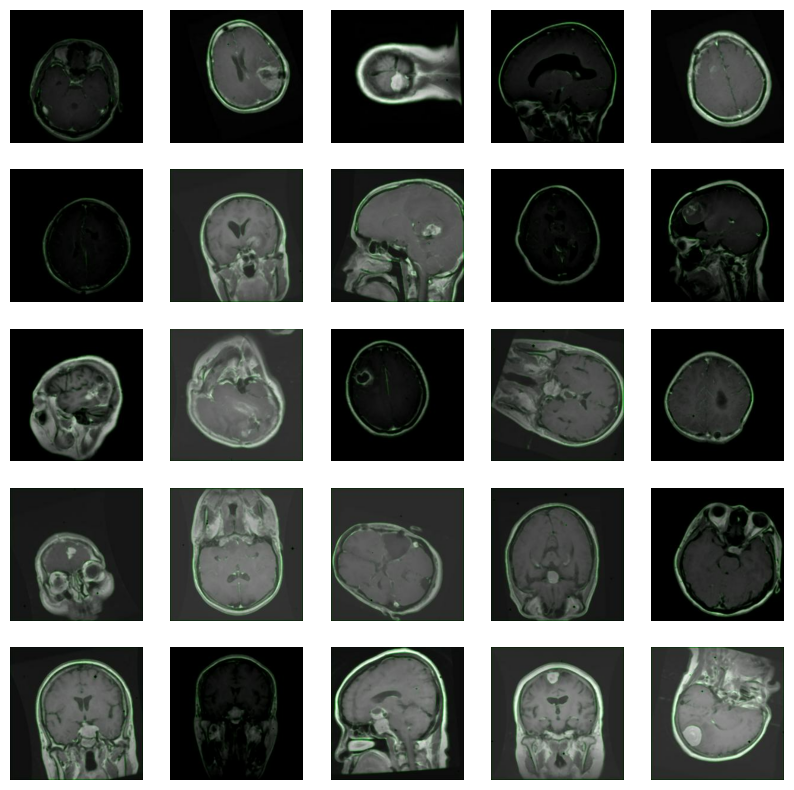

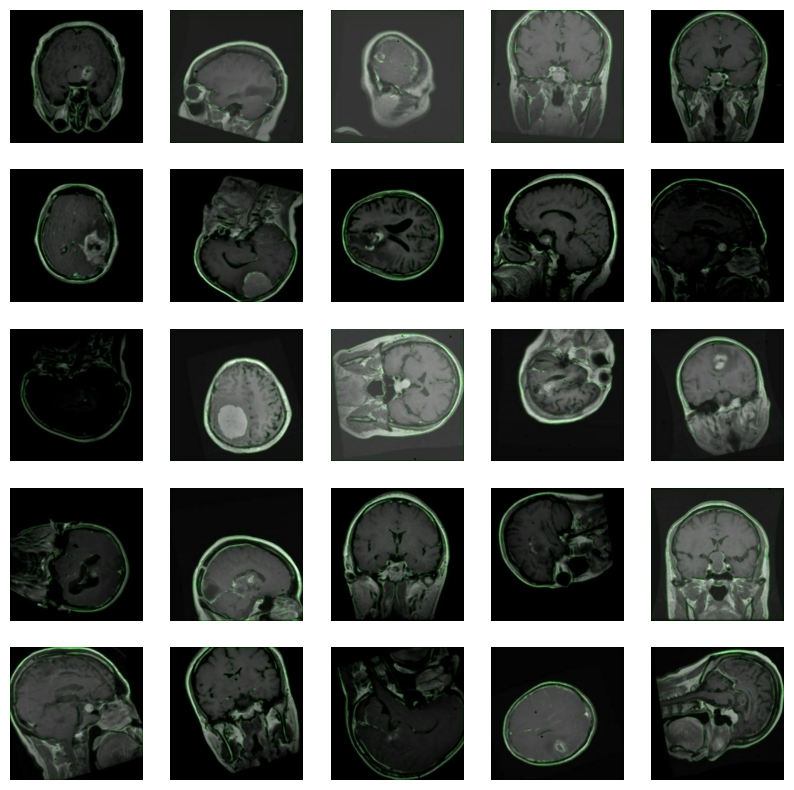

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(classes[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(classes[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 3)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
model = keras.models.load_model('/kaggle/input/braincancerclassifiaction-initial-training/BCCv4')

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0     

In [15]:
base_model = model.get_layer(index=3)
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [16]:
base_learning_rate= 0.0001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0     

In [18]:
fine_tune_epochs = 10
history_fine = model.fit(train_ds,
                         epochs=fine_tune_epochs,
                        
                         validation_data=val_ds)

Epoch 1/10
307/307 [==============================] - 67s 103ms/step - loss: 0.2529 - accuracy: 0.8978 - val_loss: 0.2213 - val_accuracy: 0.9097
Epoch 2/10
307/307 [==============================] - 29s 93ms/step - loss: 0.1385 - accuracy: 0.9465 - val_loss: 0.2044 - val_accuracy: 0.9204
Epoch 3/10
307/307 [==============================] - 29s 94ms/step - loss: 0.0718 - accuracy: 0.9731 - val_loss: 0.2026 - val_accuracy: 0.9270
Epoch 4/10
307/307 [==============================] - 29s 94ms/step - loss: 0.0413 - accuracy: 0.9837 - val_loss: 0.2256 - val_accuracy: 0.9184
Epoch 5/10
307/307 [==============================] - 29s 94ms/step - loss: 0.0247 - accuracy: 0.9910 - val_loss: 0.2532 - val_accuracy: 0.9255
Epoch 6/10
307/307 [==============================] - 29s 94ms/step - loss: 0.0167 - accuracy: 0.9944 - val_loss: 0.2786 - val_accuracy: 0.9280
Epoch 7/10
307/307 [==============================] - 29s 94ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.2750 - val_accuracy

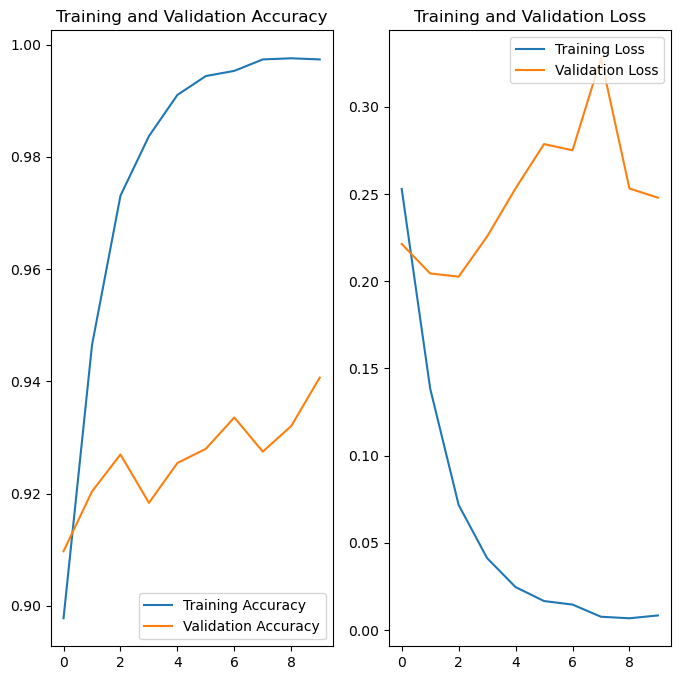

In [19]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs_range = range(fine_tune_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print('Test loss : ', loss)

15/15 [==============================] - 1s 62ms/step - loss: 0.1243 - accuracy: 0.9750
Test accuracy : 0.9750000238418579
Test loss :  0.12425044178962708


In [21]:
#saving the entire Model
model.save("/kaggle/working/BCCv4")